In [53]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 

In [54]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
#Trade data for Boeing
data_ba = pdr.get_data_yahoo('BA', '2-March-19') 
data_ba.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-04,444.500000,426.630005,443.220001,432.690002,5971000.0,422.555725
2019-03-05,433.850006,428.640015,431.040009,430.119995,2844300.0,420.045898
2019-03-06,432.000000,422.079987,429.700012,424.459991,4159400.0,414.518463
2019-03-07,434.350006,416.440002,423.359985,422.559998,4893600.0,412.662964
2019-03-08,423.429993,415.500000,416.769989,422.540009,3794900.0,412.643463


In [55]:
#Moving average crossover strategy
data_ba['9_SMA'] = data_ba['Close'].rolling(window=9).mean()
data_ba['50_SMA'] = data_ba['Close'].rolling(window=50).mean()

data_ba = data_ba[data_ba['50_SMA'].notna()]

# MA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(data_ba)-1):
    if ((data_ba['9_SMA'].values[i] < data_ba['50_SMA'].values[i]) & (data_ba['9_SMA'].values[i+1] > data_ba['50_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=data_ba.index[i].date()))
        Trade_Buy.append(i)
    elif ((data_ba['9_SMA'].values[i] > data_ba['50_SMA'].values[i]) & (data_ba['9_SMA'].values[i+1] < data_ba['50_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=data_ba.index[i].date()))
        Trade_Sell.append(i)

Trade Call for 2019-06-21 is Buy.
Trade Call for 2019-07-09 is Sell.
Trade Call for 2019-07-12 is Buy.
Trade Call for 2019-07-30 is Sell.
Trade Call for 2019-08-29 is Buy.
Trade Call for 2019-10-21 is Sell.
Trade Call for 2019-11-20 is Buy.
Trade Call for 2019-12-04 is Sell.
Trade Call for 2020-02-11 is Buy.
Trade Call for 2020-02-25 is Sell.
Trade Call for 2020-05-26 is Buy.


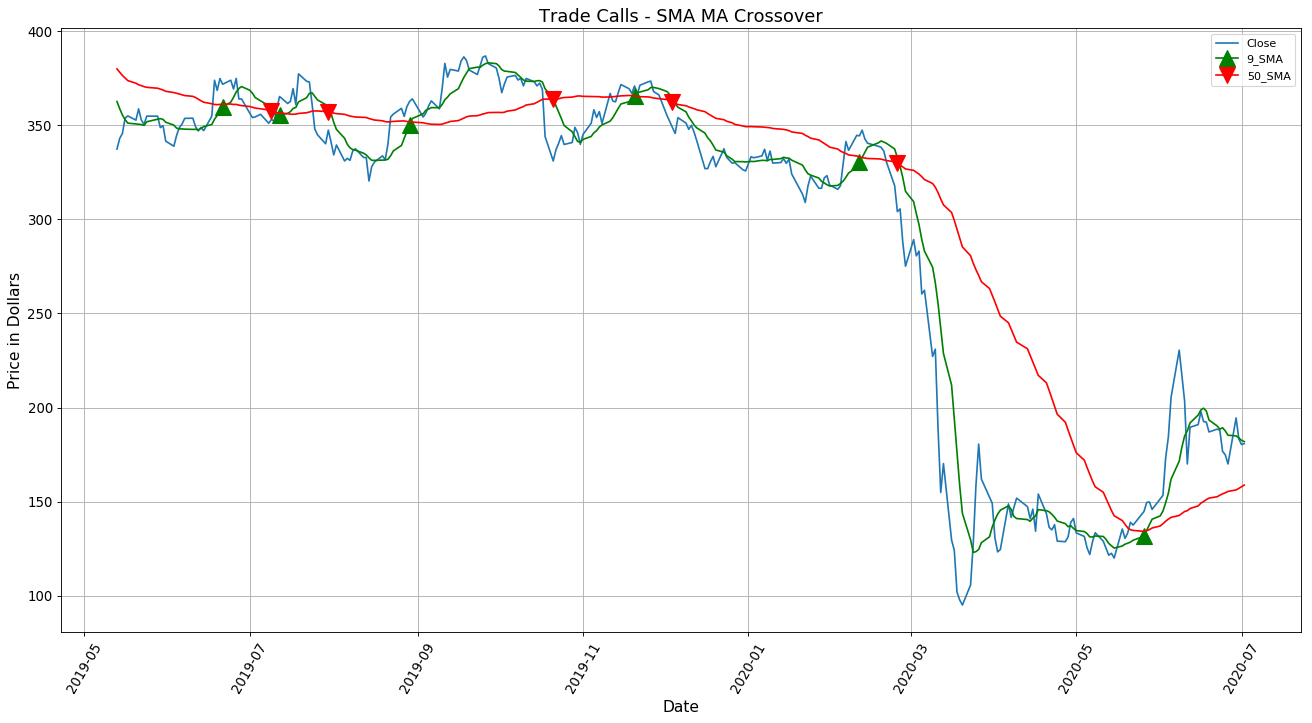

In [56]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_ba.index, data_ba['Close'])
plt.plot(data_ba.index, data_ba['9_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(data_ba.index, data_ba['50_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - SMA MA Crossover', fontsize = 16)
plt.legend(['Close','9_SMA','50_SMA'])
plt.grid()
plt.show() 

In [57]:
#NEWS TRADING STRATEGY 
# News API
url = 'https://newsapi.org/v2/everything?'

# Parameters
parameters = {
    'q': 'Boeing', # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', # your own API key
}

# API request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

final_news = news_df.loc[:,['publishedAt','title']]
final_news['publishedAt'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by='publishedAt',inplace=True)

# Business day dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Trading time for news headlines
final_news["trading_time"] = final_news["publishedAt"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)

In [58]:
#NLTK Imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [59]:
cs = []
for row in range(len(final_news)):
    cs.append(analyzer.polarity_scores(final_news['title'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

final_news.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
32,2020-07-01 20:33:06+00:00,"US STOCKS-S&P, Nasdaq close higher on vaccine ...",2020-07-02 13:30:00+00:00,2020-07-02,0.6808
33,2020-07-02 06:52:00+00:00,UPDATE 1-Meggitt warns of sales drop as virus ...,2020-07-02 13:30:00+00:00,2020-07-02,-0.3612
34,2020-07-02 07:01:49+00:00,Meggitt warns of sales drop as virus hits air ...,2020-07-02 13:30:00+00:00,2020-07-02,-0.3612
35,2020-07-02 23:34:07+00:00,Elisabeth Kübler-Ross: The rise and fall of th...,2020-07-03 13:30:00+00:00,2020-07-03,-0.4939
36,2020-07-03 02:01:00+00:00,Boeing communications chief resigns over decad...,2020-07-03 13:30:00+00:00,2020-07-03,-0.5719


In [60]:
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

In [61]:
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores

extreme_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-04,0.4588,0.0000,0.4588
1,2020-06-10,0.6249,0.0000,0.6249
2,2020-06-23,0.4588,0.0000,0.4588
3,2020-06-24,0.4404,-0.6597,-0.2193
4,2020-06-25,0.4939,-0.4767,0.0172


In [62]:
# VADER trade calls
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

Trade Call for 2020-06-04 is Buy.
Trade Call for 2020-06-10 is Buy.
Trade Call for 2020-06-23 is Buy.
Trade Call for 2020-06-24 is Sell.
Trade Call for 2020-06-29 is Buy.
Trade Call for 2020-06-30 is Sell.
Trade Call for 2020-07-02 is Buy.
Trade Call for 2020-07-03 is Sell.


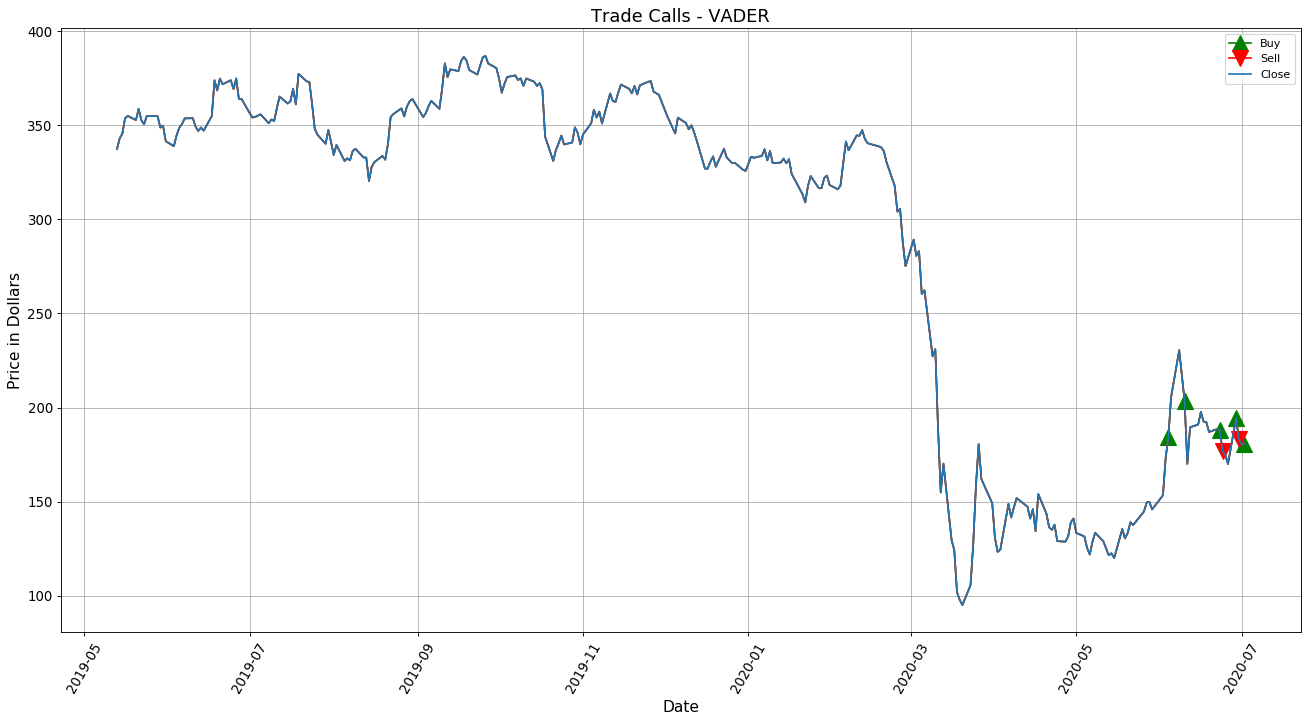

In [66]:
vader_buy = []
for i in range(len(data_ba)):
    if data_ba.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data_ba)):
    if data_ba.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_ba.index, data_ba['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plt.plot(data_ba.index, data_ba['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plt.plot(data_ba.index, data_ba['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show()

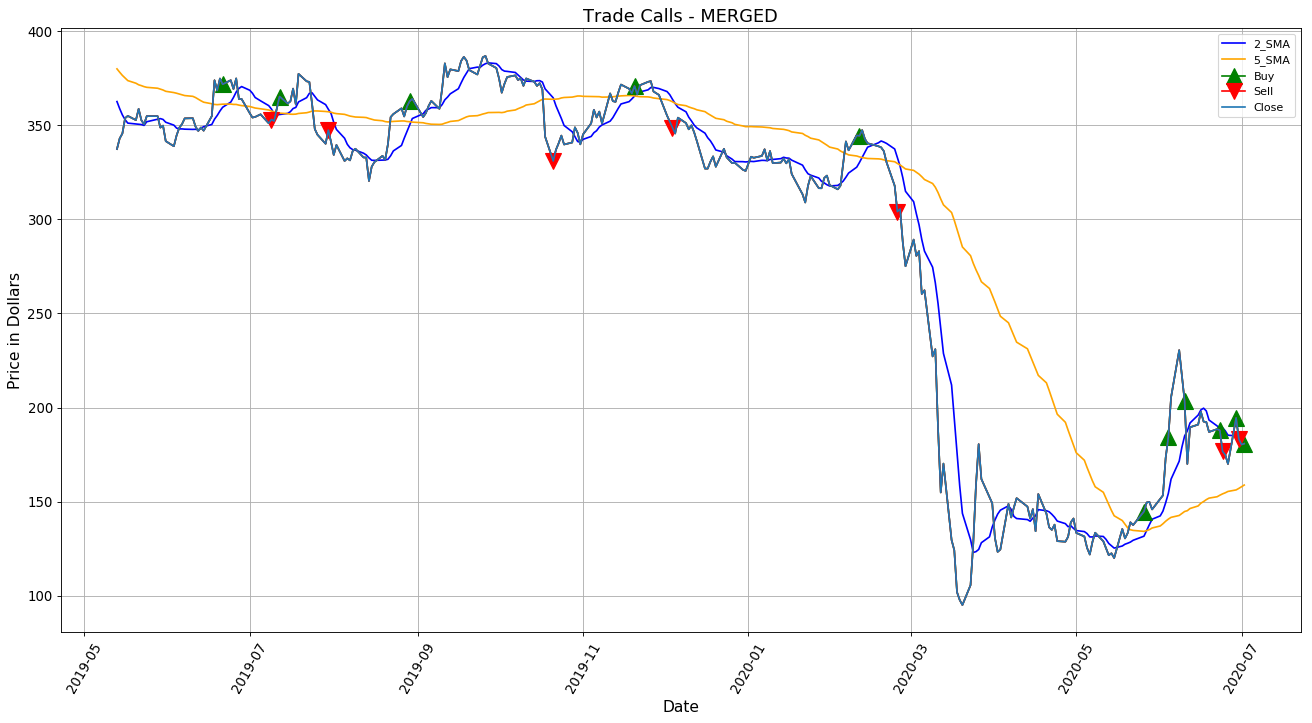

In [69]:
#SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_ba.index, data_ba['9_SMA'], color='blue')
plt.plot(data_ba.index, data_ba['50_SMA'], color='orange')
plt.plot(data_ba.index, data_ba['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(data_ba.index, data_ba['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(data_ba.index, data_ba['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show()